In [1]:
%%capture
%pip install -U torch-snippets transformers kaggle

In [2]:
%reload_ext autoreload
%autoreload 2
from torch_snippets import *

In [3]:
from transformers import ViTModel, ViTConfig
from torch.optim import Adam

model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [4]:
%%writefile kaggle.json
{"username":"kishorea", "key":"771a1a6932690961cadb8282f3ed40fc"}

Writing kaggle.json


In [5]:
%%capture
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

In [6]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [7]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = Glob(folder+'/cats/*.jpg')
        dogs = Glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.name.startswith('dog') for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = str(self.fpaths[ix])
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [8]:
ViTConfig()

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.41.2"
}

In [9]:
class ViT(nn.Module):
  def __init__(self, config=ViTConfig(), num_labels=1,
               model_checkpoint='google/vit-base-patch16-224-in21k'):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier1 = (
            nn.Linear(config.hidden_size, 128)
        )
        self.classifier2 = (
            nn.Linear(128, num_labels)
        )
        self.classifier = nn.Sequential(
            self.classifier1,
            nn.ReLU(),
            self.classifier2)
        for param in self.vit.parameters():
            param.requires_grad = False

  def forward(self, x):
    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])
    output = torch.sigmoid(output)
    return output

In [10]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [11]:
trn_dl, val_dl = get_data()
data = CatsDogs(train_data_dir)
model = ViT().to('cuda')
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

n_epochs = 5
report = Report(n_epochs)
for epoch in range(n_epochs):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    n = len(trn_dl)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        report.record(epoch+(ix+1)/n, trn_loss=batch_loss, trn_acc=np.mean(is_correct), end='\r')

    n = len(val_dl)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        report.record(epoch+(ix+1)/n, val_acc=np.mean(val_is_correct), end='\r')

    report.report_avgs(epoch+1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:81: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EPOCH: 1.000  val_acc: 0.989  trn_acc: 0.984  trn_loss: 0.246  (41.03s - 164.10s remaining)
EPOCH: 2.000  val_acc: 0.989  trn_acc: 0.996  trn_loss: 0.023  (80.85s - 121.27s remaining)
EPOCH: 3.000  val_acc: 0.990  trn_acc: 0.993  trn_loss: 0.022  (122.98s - 81.99s remaining)
EPOCH: 4.000  val_acc: 0.991  trn_acc: 0.997  trn_loss: 0.012  (164.80s - 41.20s remaining)
EPOCH: 5.000  val_acc: 0.991  trn_acc: 0.999  trn_loss: 0.008  (206.47s - 0.00s remaining)


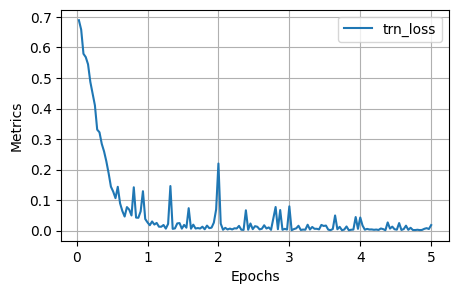

100%|██████████| 106/106 [00:00<00:00, 10501.86it/s]


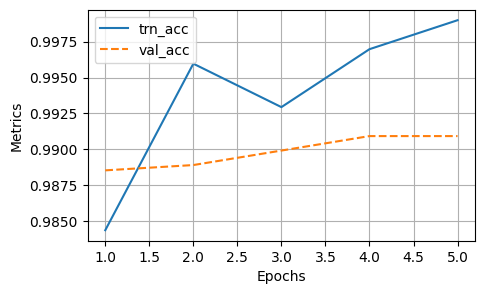

In [12]:
report.plot(['trn_loss'], sz=3, figsize=(5,3))
report.plot_epochs(['trn_acc','val_acc'], figsize=(5,3))